# Projet 6 - Analysez les ventes d'une librairie avec R ou Python
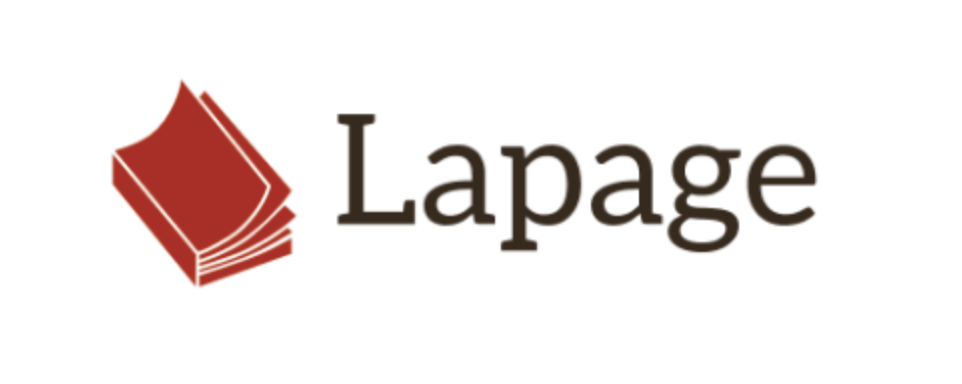

In [1]:
#Librairies 
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn as sk
from sklearn import ensemble
from sklearn import metrics

In [2]:
#Mise en forme fond graphique 
sns.set_theme()

# Analyse des données
## Importation des données

In [3]:
#Importation des données
data = pd.read_csv('Librairie_Lapage_preparation_bdd.csv', sep='\t')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658664 entries, 0 to 658663
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   658664 non-null  int64  
 1   index        658664 non-null  int64  
 2   id_prod      658664 non-null  object 
 3   date         658664 non-null  object 
 4   session_id   658664 non-null  object 
 5   client_id    658664 non-null  object 
 6   sex          658664 non-null  object 
 7   birth        658664 non-null  int64  
 8   price        658664 non-null  float64
 9   categ        658664 non-null  float64
 10  date_fixe    658664 non-null  object 
 11  year         658664 non-null  int64  
 12  month        658664 non-null  int64  
 13  yearmonth    658664 non-null  int64  
 14  age          658664 non-null  int64  
 15  classe_age   658664 non-null  object 
 16  size_idprod  658664 non-null  int64  
dtypes: float64(2), int64(8), object(7)
memory usage: 85.4+ MB


In [5]:
data.sample()

,Unnamed: 0,index,id_prod,date,session_id,client_id,sex,birth,price,categ,date_fixe,year,month,yearmonth,age,classe_age,size_idprod
597968,597968,616786,1_381,2022-06-07 19:20:37.738581,s_220325,c_2070,m,2003,15.99,1.0,2022-06-07,2022,6,202206,19,18-30,1770


Je vois que lors de l'ouverture de mon df data, la date a changer de type. Je fais la modification et je supprime la colonne 'unnamed:0'.

In [6]:
del data['Unnamed: 0']
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658664 entries, 0 to 658663
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   index        658664 non-null  int64         
 1   id_prod      658664 non-null  object        
 2   date         658664 non-null  datetime64[ns]
 3   session_id   658664 non-null  object        
 4   client_id    658664 non-null  object        
 5   sex          658664 non-null  object        
 6   birth        658664 non-null  int64         
 7   price        658664 non-null  float64       
 8   categ        658664 non-null  float64       
 9   date_fixe    658664 non-null  object        
 10  year         658664 non-null  int64         
 11  month        658664 non-null  int64         
 12  yearmonth    658664 non-null  int64         
 13  age          658664 non-null  int64         
 14  classe_age   658664 non-null  object        
 15  size_idprod  658664 non-null  int6

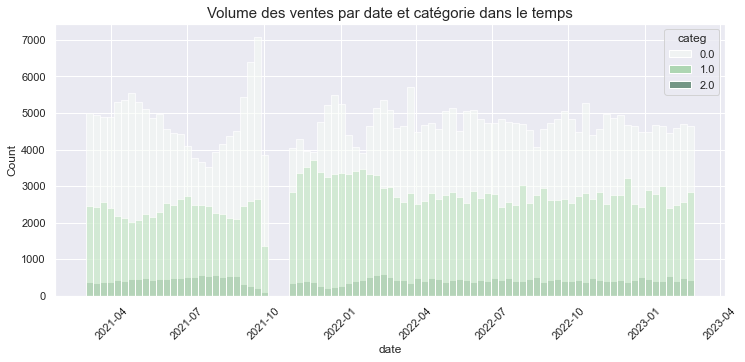

In [7]:
# Pour rappel j'ai supprimé toutes les colonnes du mois d'octobre 2021, l'analyse est donc sans octobre 2021
plt.figure(figsize=(12,5))
sns.histplot(data=data, x='date', hue='categ', palette='Greens')
plt.xticks(rotation=45)
plt.title('Volume des ventes par date et catégorie dans le temps', fontsize=15)
plt.show()

# Demande de Antoine

1. Analyse du CA
    - indicateurs (min, max, my...)
    - graphique du CA montrant l'évolution dans le temps
    - moyenne mobile pour évaluer la tendance globale 
2. Zoom sur les références 
    - les tops et les flops produits
    - répartition par catégorie
3. Profli client
    - repartition du CA entre les clients (courbe de lorenz)
    - âge / genre ...

## 1. Analyse du CA

<b> Indicateurs </b>

In [8]:
#Indicateurs statistiques de toutes les catégories
print('Catégorie 0,1,2 :',
    '\n- Prix moyen :', round(data['price'].mean(), 2), # Prix moyen
    '\n- Prix médian :', data['price'].median(), # Prix médian
    '\n- Mode :', data['price'].mode().values[0], # Prix le plus fréquent
    '\n- Prix Min :', data['price'].min(), # Prix le moins élevé 
    '\n- Prix Max :', data['price'].max(), # Prix le plus élevé
    '\n- CA par genre m :', round(data[data['sex']=='m']['price'].sum(),2), # CA par genre masculin
    '\n- CA par genre f :', round(data[data['sex']=='f']['price'].sum(),2), # CA par genre feminin
    '\n- CA total :', round(data['price'].sum(),2)) # CA total

Catégorie 0,1,2 : 
- Prix moyen : 17.54 
- Prix médian : 13.99 
- Mode : 15.99 
- Prix Min : 0.62 
- Prix Max : 300.0 
- CA par genre m : 5837219.13 
- CA par genre f : 5714253.79 
- CA total : 11551472.92


<b> Evolution CA </b>

In [9]:
#Création d'un df pour calculer l'evolution du CA 
analyse_MM = data.groupby('date_fixe').sum().reset_index()

In [10]:
analyse_MM.sample()

,date_fixe,index,birth,price,categ,year,month,yearmonth,age,size_idprod
270,2021-12-26,366980545,2146231,17094.07,452.0,2194806,13032,219493632,49661,796074


<Figure size 1440x576 with 0 Axes>

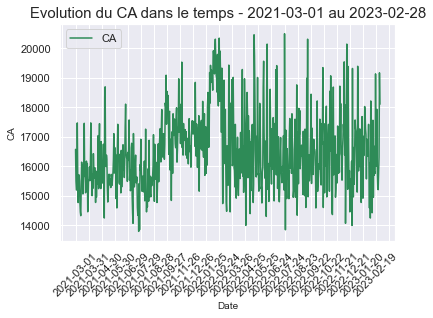

In [11]:
#Graphique du CA montrant l'évolution dans le temps
plt.figure(figsize=(20,8))

x = analyse_MM['date_fixe']
y = analyse_MM['price']

tick_spacing = 30

fig, ax = plt.subplots(1,1)
ax.plot(x,y, color ='seagreen', label = 'CA')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.title('Evolution du CA dans le temps - 2021-03-01 au 2023-02-28', fontsize=15)
plt.xlabel('Date', fontsize=10)
plt.xticks(rotation=45)
plt.ylabel('CA', fontsize=10)
plt.legend(loc = 'best')
plt.show()

<b>Interpretation : </b> nous pouvons voir que depuis mars 2021, l'entreprise vend pour un minimum 14000 euros par jour. 

<b> Evolution CA </b>

In [12]:
#Ajout de données pour calculer la moyenne mobile 
analyse_MM['mean'] = analyse_MM['price'].rolling(20).mean()
analyse_MM['std'] = analyse_MM['price'].rolling(20).std()

<Figure size 1440x576 with 0 Axes>

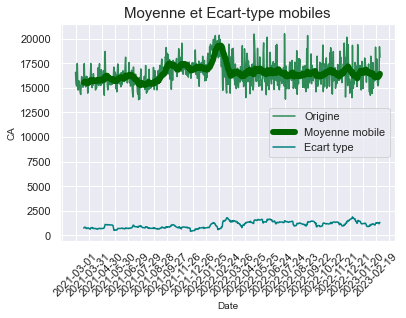

In [13]:
#Graphique de la moyenne mobile sur le CA
plt.figure(figsize=(20,8))

x = analyse_MM['date_fixe']
a = analyse_MM['price']
b = analyse_MM['mean']
c = analyse_MM['std']

tick_spacing = 30

fig, ax = plt.subplots(1,1)

plt.plot(x,a, color = ('seagreen'), label = 'Origine')
plt.plot(x,b, color = ('darkgreen'), label = 'Moyenne mobile', linewidth=6)
plt.plot(x,c, color = ('teal'), label = 'Ecart type')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.legend()
plt.title('Moyenne et Ecart-type mobiles', fontsize=15 )
plt.xlabel('Date', fontsize=10)
plt.xticks(rotation=45)
plt.ylabel('CA', fontsize=10)
plt.show()

<b> Interpretation : </b> nous pouvons voir que nous avons une tendance à la hausse de aout 2021 à fevrier 2022.  
Cependant depuis les CA stagne, nous maintenons notre CA il n'y a pas de tendance significative, il n'y a pas d'ecart notable.  
Depuis mars 2021 jusqu'à aujourd'hui nous avons une légère tendance à la hausse.

## 2. Zoom sur les références

Pour commencer regardons les données que nous avons sur les différentes categories lié aux références, en effet chaque produit est rattaché à une categorie 0,1,2.

In [14]:
#Je créé un df pour analyser la variable categorie
data_categ = data.groupby('categ').agg({"id_prod" :[np.size], "price" :[np.sum]}).reset_index()
data_categ['prop_CA']= round((data_categ['price', 'sum']/data_categ['price', 'sum'].sum())*100,2)
data_categ['prop_size']= round((data_categ['id_prod', 'size']/data_categ['id_prod', 'size'].sum())*100,2)
data_categ.head()

,categ,id_prod,price,prop_CA,prop_size
,,size,sum,,
0,0.0,397466,4228542.07,36.61,60.34
1,1.0,225845,4627222.04,40.06,34.29
2,2.0,35353,2695708.81,23.34,5.37


In [15]:
data_categ['categ']= data_categ['categ'].astype('object')
data_categ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (categ, )        3 non-null      object 
 1   (id_prod, size)  3 non-null      int64  
 2   (price, sum)     3 non-null      float64
 3   (prop_CA, )      3 non-null      float64
 4   (prop_size, )    3 non-null      float64
dtypes: float64(3), int64(1), object(1)
memory usage: 248.0+ bytes


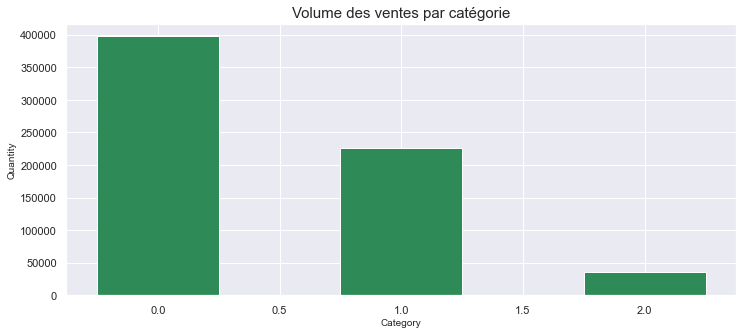

In [16]:
# Poid des catégories en nb de vente (volume)
categ = data_categ['categ']
id_size_cat = data_categ['id_prod','size']
plt.figure(figsize=(12,5))
plt.bar(categ ,id_size_cat, width = 0.5, color = 'seagreen',  edgecolor = 'white')
plt.title('Volume des ventes par catégorie', fontsize=15)
plt.xlabel('Category', fontsize=10)
plt.ylabel('Quantity', fontsize=10)
plt.show()

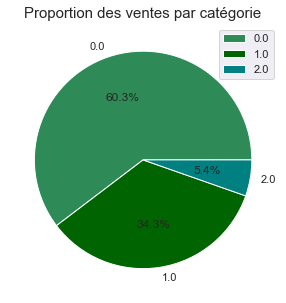

In [17]:
# Proportion des catégories en volume
labels_categ = data_categ['categ']
colors3 = ['seagreen', 'darkgreen', 'teal']
plt.figure(figsize=(12,5))
plt.pie(data_categ['prop_size'], labels=labels_categ, autopct='%1.1f%%', colors=colors3)
plt.title('Proportion des ventes par catégorie', fontsize=15)
plt.legend()
plt.show()

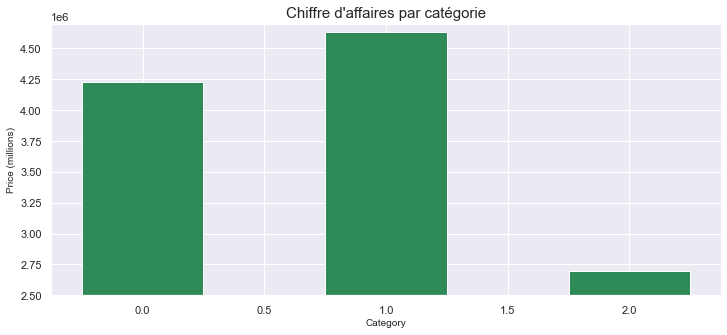

In [18]:
# Poid des catégories en valeur
categ = data_categ['categ']
CA_cat = data_categ['price','sum']
plt.figure(figsize=(12,5))
plt.bar(categ ,CA_cat, width = 0.5, color = 'seagreen')
plt.title("Chiffre d'affaires par catégorie", fontsize=15)
plt.xlabel('Category', fontsize=10)
plt.ylim([2500000, 4700000])
plt.ylabel('Price (millions)', fontsize=10)
plt.show()

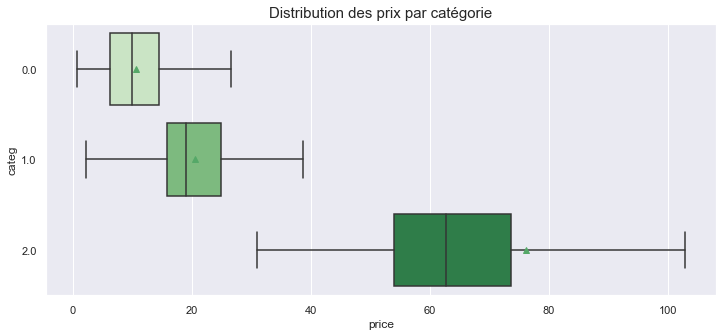

In [19]:
#Distribution des prix par categories 
plt.figure(figsize=(12,5))
sns.boxplot(
    data=data, y='categ', x='price', 
    showmeans=True, showfliers=False, orient='h', palette='Greens')
plt.title('Distribution des prix par catégorie', fontsize=15)
plt.show()

<b> Interpretation : </b> Concernant les graphiques ci-dessus :
- la categorie 0, les prix sont plutot bas, avec une moyenne de prix a 10euros, cette catégorie comptabilise 60,3% des ventes.(top2 CA)
- la categorie 1 la moyenne de prix est a 20euros et comptabilise 34,3% des ventes. (top1 CA)
- la categorie 2 la moyenne de prix d'environ 75euros et comptabilise 5,4% des ventes. (top 3 CA)
Ce que nous pouvons déduire c'est que la catégorie 0 correspondrait au livre d'entré de gamme (livre de poche), la categorie 1 au livre milieu de gamme, et la categorie 2 au livre haut de gamme.
Les livres de milieu de gamme sont les produits qui fonctionent le mieux pour l'entreprise.

En analysant la distribution des prix par catégorie, nous pouvons voir qu'il y a de grans écart de prix.  
Mesurons si il y a une inégalité dans la distribution 'price' grâce à la courbe de Lorenz.

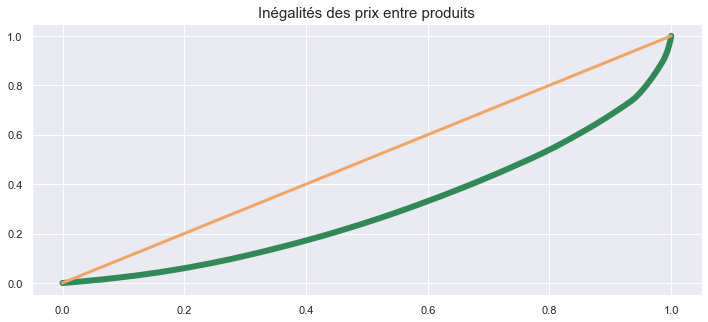

In [20]:
#Courbe de lorenz et indice de Gini sur la variable price 
price = data['price']
n = len(price)
lorenz = np.cumsum(np.sort(price)) / price.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,n+1) 
#Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. 
#Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.figure(figsize=(12,5))
plt.plot(xaxis,lorenz,linewidth=6, c='seagreen')
plt.plot([0,1], [0,1],linewidth=3,color='sandybrown' ) #tracer la bisséctrice
plt.title("Inégalités des prix entre produits", fontsize=15)
plt.show()

<b> Interprétation :</b> nous pouvons voir avec la courbe qu'il y a une inégalité des prix sur l'ensemble des produits.  
Calculons l'indice de Gini pour mesurer cette inégalité.

<b>Indice de Gini : </b> chiffre de 0 à 1 mesurant l'aire entre la bissectrice et la courbe de Lorenz :
- un coefficient de 0 indiquerait une égalité parfaite (tous les points s'aligneraient alors sur la bissectrice, réduisant l'aire à 0)
- si l'indice était de 1, un seul client détiendrait la totalité du chiffre d'affaires (l'aire serait égale à celle du triangle prenant la bissectrice comme côté et 1:1 comme angle opposé)

In [21]:
#Calcul de l'indice de Gini 
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. 
#Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, 
#on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini1 = 2*S
gini1

0.3944036982583067

<b>Interpretations : </b> l'indice de Gini nous montre bien une inégalité mais pas trés forte, avec un indice a 0,39.

In [22]:
# Indicateurs de position des prix dans chaque catégorie
for i in sorted(data['categ'].unique()):
    print('Catégorie', i)
    print(pd.Series(data[data['categ']==i]['price'].describe())),
    print('- Mode :', pd.Series(data[data['categ']==i]['price'].mode().values[0]),'\n')

Catégorie 0.0
count    397466.000000
mean         10.638752
std           4.933504
min           0.620000
25%           6.290000
50%           9.990000
75%          14.450000
max          40.990000
Name: price, dtype: float64
- Mode : 0    4.99
dtype: float64 

Catégorie 1.0
count    225845.000000
mean         20.488486
std           7.589324
min           2.000000
25%          15.810000
50%          19.080000
75%          24.980000
max          80.990000
Name: price, dtype: float64
- Mode : 0    15.99
dtype: float64 

Catégorie 2.0
count    35353.000000
mean        76.251204
std         39.806807
min         30.990000
25%         53.990000
50%         62.830000
75%         73.720000
max        300.000000
Name: price, dtype: float64
- Mode : 0    68.99
dtype: float64 



In [23]:
#Nombre de référence par catégorie
df_count_ref = (data[['id_prod', 'categ']].copy()
          .groupby(['id_prod','categ'])
          .count().reset_index()
          .groupby(['categ'])
          .count())
df_count_ref

,id_prod
categ,
0.0,2291
1.0,737
2.0,236


<b>Interpretation : </b>nous pouvons voir que la catégorie 0 compte le plus de reference.

<b> Les tops et les flops produits par catégorie <b>

In [24]:
#Je créé une table pour analyser les references de chaque categorie
data_tf = data.copy()
data_tf.sample()

,index,id_prod,date,session_id,client_id,sex,birth,price,categ,date_fixe,year,month,yearmonth,age,classe_age,size_idprod
610548,629757,1_378,2022-02-10 02:20:00.029215,s_162726,c_3653,m,1962,26.61,1.0,2022-02-10,2022,2,202202,60,60-70,1725


In [25]:
#Avant de faire un groupby sur id_prod, j'extrait les données dont j'aurai besoin par la suite.
size_id_prod = data_tf[['id_prod','categ','size_idprod']]
size_id_prod.sample()

,id_prod,categ,size_idprod
260795,1_414,1.0,2170


In [26]:
def doublons(df): # Nombre de doublons dans la dataframe
    print(len(df) - len(df.drop_duplicates()), 'doublons')

In [27]:
#Je vérifie et supprime les doublons 
doublons(size_id_prod)
size_id_prod = size_id_prod.drop_duplicates()

655400 doublons


In [28]:
#Je simplifie ma table data_tf
data_tf = data_tf[['id_prod','price']]
data_tf.sample()

,id_prod,price
194630,0_1298,18.32


In [29]:
#Je fais un groupby sur id_prod
data_tf = data_tf.groupby('id_prod').sum()
#Je remplace le nom de ma colonne price, car avec le sum cela représente le CA par produit
data_tf.rename(columns = {'price':'CA_product'}, inplace = True)
data_tf.sample()

,CA_product
id_prod,
0_1667,862.92


In [30]:
#Je fais une jointure avec ma table size_id_prod
data_tf2 = pd.merge(data_tf, size_id_prod, how='left', on='id_prod')
data_tf2.sample()
#Je vérifie que tout s'est bien passé
data_tf2.info()
#Je vérifie que je n'ai pas de doublons dans id_prod
doublons(data_tf2['id_prod'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3264 entries, 0 to 3263
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_prod      3264 non-null   object 
 1   CA_product   3264 non-null   float64
 2   categ        3264 non-null   float64
 3   size_idprod  3264 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 127.5+ KB
0 doublons


Je filtre ensuite mes données par catégorie pour ensuite les trier dans l'ordre que je souhaite et obtenir le haut ou le bas de la liste en terme de CA ou de nb de vente.

In [31]:
#Top produit categ / 0 nb vente
data_tf_categ0_size_top = data_tf2[(data_tf2['categ']== 0)].sort_values(by=['size_idprod']).tail(10)
data_tf_categ0_size_top.head(10)

,id_prod,CA_product,categ,size_idprod
478,0_1434,10124.40,0.0,1180
471,0_1428,4189.00,0.0,1180
486,0_1441,22427.19,0.0,1181
453,0_1411,10725.07,0.0,1193
476,0_1432,18339.84,0.0,1194
467,0_1424,10049.95,0.0,1195
0,0_0,4485.00,0.0,1196
468,0_1425,15821.82,0.0,1218
475,0_1431,13572.65,0.0,1235
465,0_1422,14091.35,0.0,1235


In [32]:
#Flop produit categ 0 / nb vente
data_tf_categ0_size_flop = data_tf2[(data_tf2['categ']== 0)].sort_values(by=['size_idprod']).head(10)
data_tf_categ0_size_flop.head(10)

,id_prod,CA_product,categ,size_idprod
801,0_1728,2.27,0.0,1
166,0_1151,2.99,0.0,1
2178,0_898,1.27,0.0,1
548,0_1498,2.48,0.0,1
664,0_1601,1.99,0.0,1
2270,0_980,31.06,0.0,1
656,0_1595,2.99,0.0,1
2165,0_886,21.82,0.0,1
594,0_1539,0.99,0.0,1
751,0_1683,2.99,0.0,1


In [33]:
#Flop produit categ 0 / CA
data_tf_categ0_CA_flop = data_tf2[(data_tf2['categ']== 0)].sort_values(by=['CA_product']).head(10)
data_tf_categ0_CA_flop.head(10)

,id_prod,CA_product,categ,size_idprod
594,0_1539,0.99,0.0,1
2178,0_898,1.27,0.0,1
313,0_1284,1.38,0.0,1
1896,0_643,1.98,0.0,2
718,0_1653,1.98,0.0,2
2078,0_807,1.99,0.0,1
1783,0_541,1.99,0.0,1
664,0_1601,1.99,0.0,1
801,0_1728,2.27,0.0,1
1543,0_324,2.36,0.0,2


In [34]:
#Top produit categ 0 / CA
data_tf_categ0_CA_top = data_tf2[(data_tf2['categ']== 0)].sort_values(by=['CA_product']).tail(10)
data_tf_categ0_CA_top.head(10)

,id_prod,CA_product,categ,size_idprod
391,0_1355,18439.29,0.0,971
389,0_1353,18650.67,0.0,933
518,0_1470,19217.52,0.0,984
474,0_1430,19286.37,0.0,1171
493,0_1448,19811.24,0.0,1046
459,0_1417,20400.66,0.0,1134
497,0_1451,20789.60,0.0,1040
456,0_1414,21414.90,0.0,1105
464,0_1421,21829.08,0.0,1092
486,0_1441,22427.19,0.0,1181


In [35]:
#Flop produit categ 1 / nb vente
data_tf_categ1_size_flop = data_tf2[(data_tf2['categ']== 1)].sort_values(by=['size_idprod']).head(10)
data_tf_categ1_size_flop.head(10)

,id_prod,CA_product,categ,size_idprod
2647,1_420,14.24,1.0,2
2627,1_402,69.04,1.0,2
2751,1_514,135.32,1.0,2
2343,1_146,95.94,1.0,3
2634,1_409,167.97,1.0,3
2633,1_408,105.72,1.0,3
2629,1_404,29.55,1.0,3
2605,1_382,246.08,1.0,4
2451,1_243,171.96,1.0,4
2728,1_494,196.64,1.0,4


In [36]:
#Top produit categ 1 / nb vente
data_tf_categ1_size_top = data_tf2[(data_tf2['categ']== 1)].sort_values(by=['size_idprod']).tail(10)
data_tf_categ1_size_top.head(10)

,id_prod,CA_product,categ,size_idprod
2632,1_407,30780.75,1.0,1925
2639,1_413,34774.67,1.0,1933
2631,1_406,47982.54,1.0,1934
2638,1_412,32334.30,1.0,1942
2628,1_403,35116.48,1.0,1952
2652,1_425,35458.13,1.0,2087
2732,1_498,49521.03,1.0,2119
2640,1_414,51711.10,1.0,2170
2643,1_417,45632.26,1.0,2174
2590,1_369,53761.59,1.0,2241


In [37]:
#Flop produit categ 1 / CA
data_tf_categ1_CA_flop = data_tf2[(data_tf2['categ']== 1)].sort_values(by=['CA_product']).head(10)
data_tf_categ1_CA_flop.head(10)

,id_prod,CA_product,categ,size_idprod
2647,1_420,14.24,1.0,2
2430,1_224,19.80,1.0,4
2702,1_470,21.64,1.0,4
2705,1_473,26.91,1.0,9
2629,1_404,29.55,1.0,3
2331,1_135,39.95,1.0,5
2622,1_399,43.89,1.0,11
2748,1_511,44.85,1.0,15
2666,1_438,47.16,1.0,9
2651,1_424,49.10,1.0,10


In [38]:
#Top produit categ 1 / CA
data_tf_categ1_CA_top = data_tf2[(data_tf2['categ']== 1)].sort_values(by=['CA_product']).tail(10)
data_tf_categ1_CA_top.head(10)

,id_prod,CA_product,categ,size_idprod
2601,1_379,45909.99,1.0,1701
2659,1_431,46379.43,1.0,1657
2608,1_385,46600.07,1.0,1793
2587,1_366,46834.14,1.0,1641
2631,1_406,47982.54,1.0,1934
2732,1_498,49521.03,1.0,2119
2606,1_383,51225.33,1.0,1767
2640,1_414,51711.10,1.0,2170
2590,1_369,53761.59,1.0,2241
2618,1_395,54095.34,1.0,1866


In [39]:
#Top produit categ 2 / nb vente
data_tf_categ2_size_top = data_tf2[(data_tf2['categ']== 2)].sort_values(by=['size_idprod']).tail(10)
data_tf_categ2_size_top.head(10)

,id_prod,CA_product,categ,size_idprod
3040,2_109,38818.81,2.0,719
3149,2_207,38854.38,2.0,762
3151,2_209,55502.07,2.0,793
3150,2_208,44225.22,2.0,806
3042,2_110,51916.50,2.0,834
3198,2_37,42474.33,2.0,867
3200,2_39,51205.17,2.0,883
3044,2_112,62840.10,2.0,930
3069,2_135,67472.22,2.0,978
3033,2_102,59080.86,2.0,999


In [40]:
#Flop produit categ 2 / nb vente
data_tf_categ2_size_flop = data_tf2[(data_tf2['categ']== 2)].sort_values(by=['size_idprod']).head(10)
data_tf_categ2_size_flop.head(10)

,id_prod,CA_product,categ,size_idprod
3174,2_23,115.99,2.0,1
3262,2_98,149.74,2.0,1
3246,2_81,86.99,2.0,1
3242,2_78,334.98,2.0,2
3065,2_131,255.98,2.0,2
3257,2_93,157.98,2.0,2
3241,2_77,291.98,2.0,2
3230,2_66,301.44,2.0,2
3188,2_28,310.50,2.0,3
3064,2_130,427.74,2.0,3


In [41]:
#Flop produit categ 2 / CA
data_tf_categ2_CA_flop = data_tf2[(data_tf2['categ']== 2)].sort_values(by=['CA_product']).head(10)
data_tf_categ2_CA_flop.head(10)

,id_prod,CA_product,categ,size_idprod
3246,2_81,86.99,2.0,1
3174,2_23,115.99,2.0,1
3262,2_98,149.74,2.0,1
3257,2_93,157.98,2.0,2
3038,2_107,203.94,2.0,6
3065,2_131,255.98,2.0,2
3055,2_122,280.00,2.0,4
3241,2_77,291.98,2.0,2
3187,2_27,295.96,2.0,4
3230,2_66,301.44,2.0,2


In [42]:
#Top produit categ 2 / CA
data_tf_categ2_CA_top = data_tf2[(data_tf2['categ']== 2)].sort_values(by=['CA_product']).tail(10)
data_tf_categ2_CA_top.head(10)

,id_prod,CA_product,categ,size_idprod
3144,2_202,44461.06,2.0,658
3205,2_43,48433.08,2.0,692
3103,2_166,51068.88,2.0,222
3200,2_39,51205.17,2.0,883
3042,2_110,51916.50,2.0,834
3151,2_209,55502.07,2.0,793
3033,2_102,59080.86,2.0,999
3044,2_112,62840.10,2.0,930
3069,2_135,67472.22,2.0,978
3095,2_159,92265.68,2.0,632


<b> Graphique Top/Flop par categorie </b>

Top CA par categorie


<BarContainer object of 10 artists>

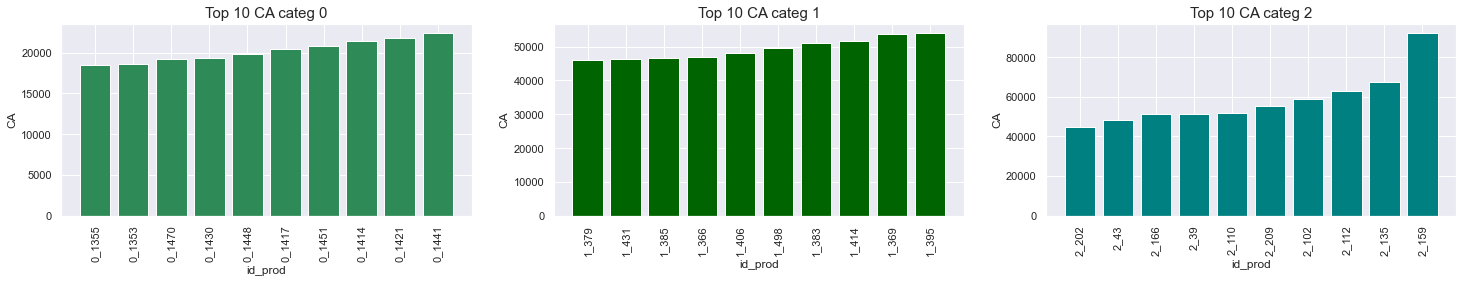

In [43]:
#Top CA par catégorie
print('Top CA par categorie')
plt.figure(figsize=(25,12))
plt.subplot(3,3,1)
plt.title("Top 10 CA categ 0",fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ0_CA_top['id_prod'], data_tf_categ0_CA_top['CA_product'], color = 'seagreen')

plt.subplot(3,3,2)
plt.title("Top 10 CA categ 1",fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ1_CA_top['id_prod'], data_tf_categ1_CA_top['CA_product'], color = 'darkgreen')

plt.subplot(3,3,3)
plt.title("Top 10 CA categ 2",fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ2_CA_top['id_prod'], data_tf_categ2_CA_top['CA_product'], color = 'teal')

Top vente par catégorie


<BarContainer object of 10 artists>

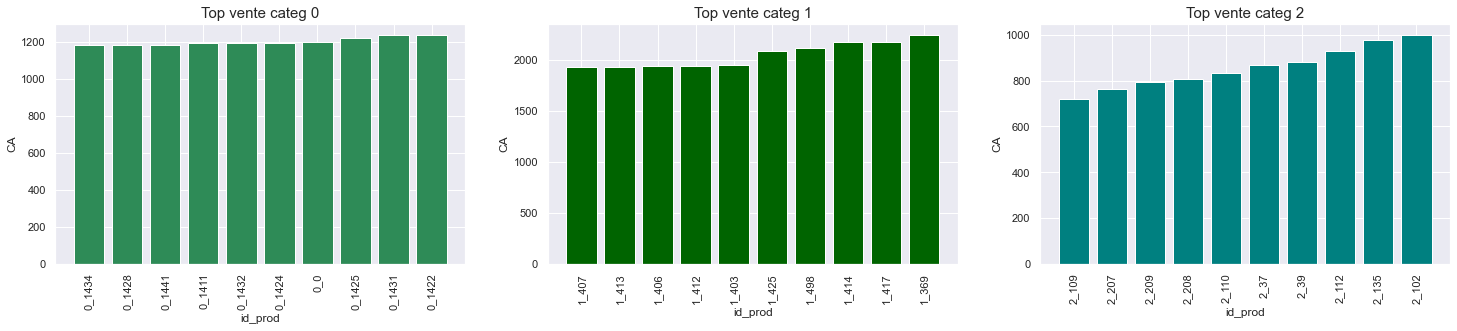

In [44]:
#Top vente par catégorie
print('Top vente par catégorie')
plt.figure(figsize=(25,15))
plt.subplot(3,3,1)
plt.title("Top vente categ 0", fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ0_size_top['id_prod'], data_tf_categ0_size_top['size_idprod'], color = 'seagreen')

plt.subplot(3,3,2)
plt.title("Top vente categ 1", fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ1_size_top['id_prod'], data_tf_categ1_size_top['size_idprod'], color = 'darkgreen')

plt.subplot(3,3,3)
plt.title("Top vente categ 2", fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ2_size_top['id_prod'], data_tf_categ2_size_top['size_idprod'], color = 'teal')

<b> Interpretations :</b> 
- Nous pouvons voir que la categorie 2 (livre haut de gamme) fait moins de vente (236 references dans la categorie) que les categories 1 & 2 mais elle rapporte plus de CA sur ses top refs.
- En terme de vente ce sont les livres de de la categorie 1 qui font le plus de vente (milieu de gamme, 737 refs)
- Il y a de grand écart de CA  entre les tops de chaque categorie : top CA categorie 0 = + de 20000 ; categorie 1 =  + de 50000 et enfin top CA categorie 2 = + de 80000.

Flop CA par catégorie


<BarContainer object of 10 artists>

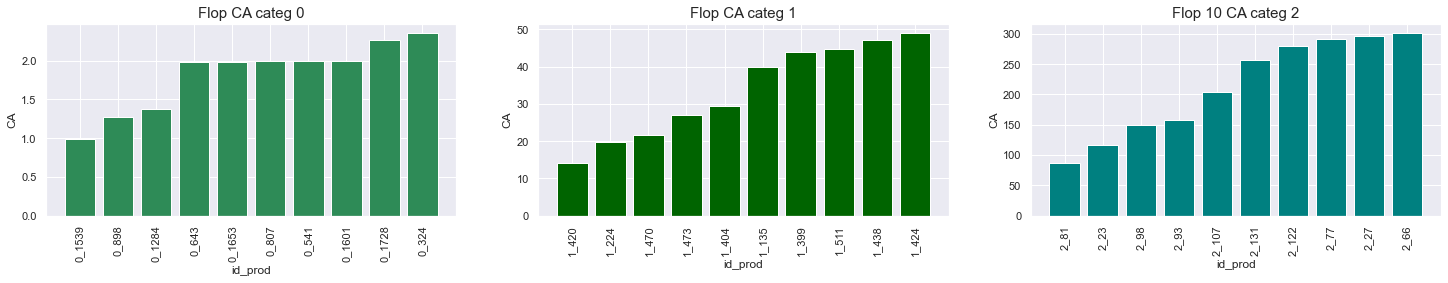

In [45]:
#Flop CA par catégorie
print('Flop CA par catégorie')
plt.figure(figsize=(25,12))
plt.subplot(3,3,1)
plt.title("Flop CA categ 0",fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ0_CA_flop['id_prod'], data_tf_categ0_CA_flop['CA_product'], color = 'seagreen')

plt.subplot(3,3,2)
plt.title("Flop CA categ 1",fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ1_CA_flop['id_prod'], data_tf_categ1_CA_flop['CA_product'], color = 'darkgreen')

plt.subplot(3,3,3)
plt.title("Flop 10 CA categ 2",fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ2_CA_flop['id_prod'], data_tf_categ2_CA_flop['CA_product'], color = 'teal')

Flop vente par catégorie


<BarContainer object of 10 artists>

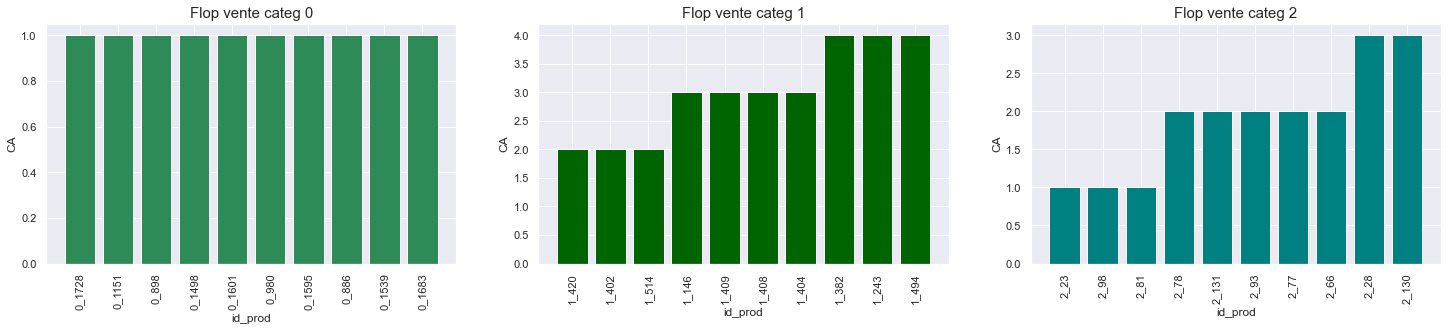

In [46]:
#Flop vente par catégorie
print('Flop vente par catégorie')
plt.figure(figsize=(25,15))
plt.subplot(3,3,1)
plt.title("Flop vente categ 0", fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ0_size_flop['id_prod'], data_tf_categ0_size_flop['size_idprod'], color = 'seagreen')

plt.subplot(3,3,2)
plt.title("Flop vente categ 1", fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ1_size_flop['id_prod'], data_tf_categ1_size_flop['size_idprod'], color = 'darkgreen')

plt.subplot(3,3,3)
plt.title("Flop vente categ 2",fontsize=15)
plt.xlabel('id_prod')
plt.ylabel('CA')
plt.xticks(rotation = '90')
plt.bar(data_tf_categ2_size_flop['id_prod'], data_tf_categ2_size_flop['size_idprod'], color = 'teal')

<b> Interpretations :</b> 
- Le flop CA categorie 0 est de 1e , de 12e pour la categorie 1 et enfin de 90e pour la categorie 2 : les flop CA sont en corrélation avec la distribution des prix dans les categories.
- En terme de nb de vente le flop categorie 0 est a 1, a 2 pour la categorie 1 et enfin à 1 pour la categorie 2.

<b> Top / Flop all categories </b>

In [47]:
#Les 15 livres qui font le plus de CA / all categories
data_tf2.sort_values('CA_product').tail(15)

,id_prod,CA_product,categ,size_idprod
2631,1_406,47982.54,1.0,1934
3205,2_43,48433.08,2.0,692
2732,1_498,49521.03,1.0,2119
3103,2_166,51068.88,2.0,222
3200,2_39,51205.17,2.0,883
2606,1_383,51225.33,1.0,1767
2640,1_414,51711.10,1.0,2170
3042,2_110,51916.50,2.0,834
2590,1_369,53761.59,1.0,2241
2618,1_395,54095.34,1.0,1866


<b> Interpretation :</b> les livres qui font le plus de CA appartiennent à la categorie 1 et 2. (categorie de prix plus haute, milieu et haut de gamme)

In [48]:
#Les 15 livres qui font le plus de vente / all categories
data_tf2.sort_values('size_idprod').tail(15)

,id_prod,CA_product,categ,size_idprod
2616,1_392,32851.54,1.0,1814
2625,1_400,30411.20,1.0,1832
2618,1_395,54095.34,1.0,1866
2619,1_396,35451.60,1.0,1906
2621,1_398,19384.02,1.0,1906
2632,1_407,30780.75,1.0,1925
2639,1_413,34774.67,1.0,1933
2631,1_406,47982.54,1.0,1934
2638,1_412,32334.30,1.0,1942
2628,1_403,35116.48,1.0,1952


<b> Interpretation :</b> les livres qui font le plus de ventes appartiennent à la categorie 1. C'est aussi la categorie qui fonctionne le mieux pour l'entreprise en terme CA total/categorie.

In [49]:
#Les 15 livres qui font le moins de CA / all categories
data_tf2.sort_values('CA_product').head(15)

,id_prod,CA_product,categ,size_idprod
594,0_1539,0.99,0.0,1
2178,0_898,1.27,0.0,1
313,0_1284,1.38,0.0,1
718,0_1653,1.98,0.0,2
1896,0_643,1.98,0.0,2
2078,0_807,1.99,0.0,1
664,0_1601,1.99,0.0,1
1783,0_541,1.99,0.0,1
801,0_1728,2.27,0.0,1
1543,0_324,2.36,0.0,2


<b> Interpretations :</b> les livres qui font le moins de CA appartiennent à la categorie 0. (categorie de prix plus basse, entré de gamme)

In [50]:
#Les 15 livres qui font le moins de vente / all categories
data_tf2.sort_values('size_idprod').head(15)

,id_prod,CA_product,categ,size_idprod
751,0_1683,2.99,0.0,1
2178,0_898,1.27,0.0,1
3246,2_81,86.99,2.0,1
697,0_1633,24.99,0.0,1
548,0_1498,2.48,0.0,1
801,0_1728,2.27,0.0,1
1783,0_541,1.99,0.0,1
313,0_1284,1.38,0.0,1
2107,0_833,2.99,0.0,1
3174,2_23,115.99,2.0,1


<b> Interpretation :</b> les livres qui font le moins de vente appartiennent à la categorie 0 et 2.

## 3. Profil client

<b> Infos sur le genre des clients </b>

<Figure size 864x360 with 0 Axes>

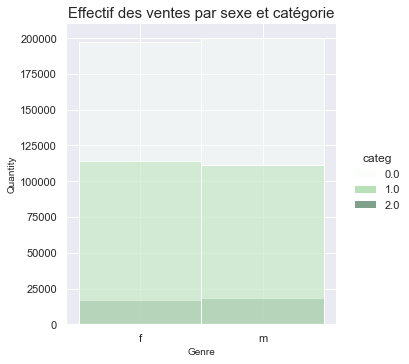

In [51]:
plt.figure(figsize=(12,5))
sns.displot(data=data, x='sex', hue='categ', palette= 'Greens')
plt.title('Effectif des ventes par sexe et catégorie', fontsize=15)
plt.xlabel('Genre', fontsize=10)
plt.ylabel('Quantity', fontsize=10)
plt.show()

In [52]:
#Nombre de id_client par genre
df_count_sex = (data[['id_prod', 'sex']].copy()
          .groupby(['id_prod','sex'])
          .count().reset_index()
          .groupby(['sex'])
          .count())
df_count_sex

,id_prod
sex,
f,3157
m,3169


<b> Infos sur l'âge des clients </b>

In [53]:
data['age'].describe()#indicateurs statistiques

count    658664.000000
mean         44.223112
std          13.615401
min          18.000000
25%          35.000000
50%          42.000000
75%          52.000000
max          93.000000
Name: age, dtype: float64

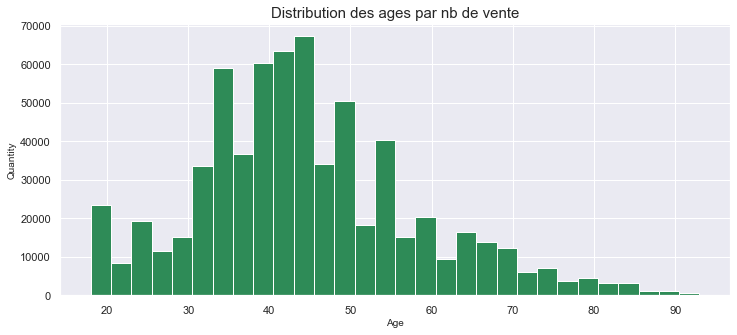

In [54]:
#Distribution des ages 
plt.figure(figsize=(12,5))
plt.hist(data['age'], bins=30, color='seagreen')
plt.title('Distribution des ages par nb de vente', fontsize=15)
plt.xlabel('Age', fontsize=10)
plt.ylabel('Quantity', fontsize=10)
plt.show()

<Figure size 864x360 with 0 Axes>

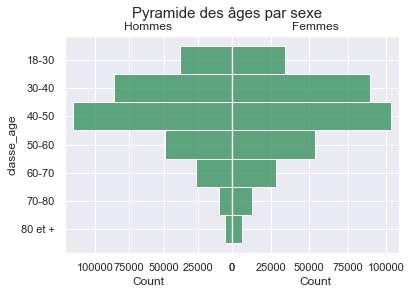

In [55]:
#Pyramide des ages 
plt.figure(figsize=(12,5))
fig, axes = plt.subplots(1, 2)
fig.suptitle('Pyramide des âges par sexe', fontsize=15)

sns.histplot(ax=axes[0], y=data[data['sex']=='m']['classe_age'].sort_values(), color='seagreen')
axes[0].invert_xaxis()
axes[0].set_title('Hommes')

sns.histplot(ax=axes[1], y=data[data['sex']=='f']['classe_age'].sort_values(), color='seagreen')
axes[1].set_yticklabels([])
axes[1].set_ylabel('')
axes[1].set_title('Femmes')

plt.subplots_adjust(wspace=0, hspace=0)#retire l'espace entre les deux graphique qui sont côte à côte
plt.show()

In [56]:
print('\n- Age par genre m :', round(data[data['sex']=='m']['age'].mean(),2), # CA par genre masculin
'\n- Age par genre f :', round(data[data['sex']=='f']['age'].mean(),2)) # CA par genre feminin


- Age par genre m : 43.66 
- Age par genre f : 44.78


<b> Interpretation : </b> 
- nous pouvons voir que la personne la moins agé de nos clients à 18 ans et la plus agée à 93 ans. 
- 75% des clients ont moins de 52 ans.
- les hommes et les femmes ont la  même moyenne d'âge.
- les 30-50ans sont les clients qui achètent le plus.
- la pyramide des ages montre les hommes et les femmes sont bien représentés sur chaque classe d'age.
- en terme d'achat pour chaque categorie, aucun ne se distingue de l'autre.

<b> Repartition du CA entre les clients </b>

Pour aller plus loin je créé un df data_client.

In [57]:
data_a = data.drop_duplicates('client_id')

In [58]:
data_b = data.groupby(data['client_id']).sum().reset_index()
data_b = data_b[['client_id','price']]

In [59]:
data_client = pd.merge(data_a, data_b, on="client_id")
data_client.sample()

,index,id_prod,date,session_id,client_id,sex,birth,price_x,categ,date_fixe,year,month,yearmonth,age,classe_age,size_idprod,price_y
3327,5767,0_1421,2021-07-29 18:26:58.514294,s_68767,c_2754,f,1986,19.99,0.0,2021-07-29,2021,7,202107,36,30-40,1092,824.44


In [60]:
data_client = data_client[['client_id','sex','birth','age','classe_age','price_y']]

In [61]:
doublons(data_client)

0 doublons


<b> Inégalités du CA entre les clients (courbe de lorenz & Gini)</b>

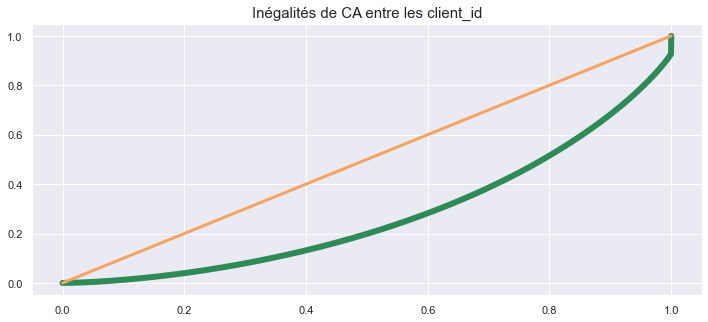

In [62]:
#Courbe de lorenz et indice de Gini sur la variable price_y (CA) 
CA = data_client['price_y']
n = len(CA)
lorenz = np.cumsum(np.sort(CA)) / CA.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,n+1) 
#Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. 
#Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.figure(figsize=(12,5))
plt.plot(xaxis,lorenz,linewidth=6, c='seagreen')
plt.plot([0,1], [0,1],linewidth=3,color='sandybrown' ) #tracer la bisséctrice
plt.title("Inégalités de CA entre les client_id", fontsize=15)
plt.show()

In [63]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. 
#Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, 
#on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.44718701642201697

<b> Interpretation : </b> La courbe de Lorenz montre une inégalité entre les CA des clients avec un indice de 0,44.  
Regardons de plus prés les CA de nos meilleurs et moins bons clients en terme de CA.

In [64]:
# Les 15 meilleurs clients 
data_client.sort_values("price_y").tail(15)

,client_id,sex,birth,age,classe_age,price_y
543,c_2595,m,1974,48,40-50,4778.69
2371,c_1876,m,1983,39,30-40,4846.94
655,c_1422,f,1980,42,40-50,4914.74
347,c_7421,m,1978,44,40-50,4944.39
2384,c_2140,f,1977,45,40-50,4949.96
1567,c_8026,m,1978,44,40-50,4979.40
1295,c_5263,m,1998,24,18-30,5006.85
677,c_7319,f,1974,48,40-50,5120.55
232,c_3263,f,1985,37,30-40,5129.89
1122,c_1570,f,1979,43,40-50,5166.45


In [65]:
# Les 15 clients faisant le moins de CA
data_client.sort_values("price_y").head(15)

,client_id,sex,birth,age,classe_age,price_y
8532,c_8140,m,1971,51,50-60,8.30
8595,c_8114,m,1962,60,60-70,9.98
8596,c_240,m,1998,24,18-30,11.06
8154,c_4648,m,2004,18,18-30,11.20
8527,c_2793,m,1933,89,80 et +,12.99
8412,c_4478,f,1970,52,50-60,13.36
8588,c_5962,f,1997,25,18-30,13.99
8309,c_6040,f,1974,48,40-50,15.72
8408,c_5919,f,1955,67,60-70,15.98
7401,c_5829,f,1989,33,30-40,16.07


<b> Interpretation :</b> On peut voir qu'il y a 4 clients qui se détache des autres avec un montant de CA sur les 2 ans de plus de 110000euros. 
Je pense que ce sont des clients professionnels. 
Ces 4 clients peuvent expliquer en partie l'inégalité entre les CA des clients.(Gini = 0,44)

# Demandes de Julie
## Analyse bivariée entre les variables suivantes :

1. Sex VS Category
2. Age VS Price
3. Age VS Purchasing Frequency
4. Age VS Volume
5. Age VS products by session
6. Age VS Category
7. Categ VS Price

Regardons dans un premier temps les corrélations entre les variable quantitative.

In [66]:
data_corr = data.copy()

In [67]:
data_corr = data_corr[['birth','price','categ','age']]

/var/folders/7p/qmwkn84d5f79vzff9sdp0zq00000gn/T/ipykernel_2542/2774578799.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.triu(np.ones_like(data_corr.corr(), dtype=np.bool)),


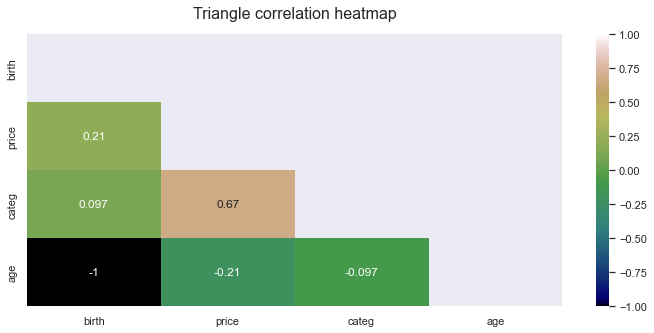

In [68]:
plt.figure(figsize=(12, 5))
heatmap = sns.heatmap(
    data_corr.corr(), 
    mask=np.triu(np.ones_like(data_corr.corr(), dtype=np.bool)), 
    vmin=-1, vmax=1, annot=True, cmap='gist_earth')
heatmap.set_title('Triangle correlation heatmap', fontdict={'fontsize':16}, pad=16)
plt.show()

## 1. Sex VS Category

Regardons le lien entre le genre d’un client et les catégories des livres achetés, pour cela nous allons utiliser le test d'indépendance du χ² (Khi2) qui mesure la corrélation entre 2 variables qualitatives.(ou Test Chi2) // sex & category // calcul avec scipy.stats.

<Figure size 864x360 with 0 Axes>

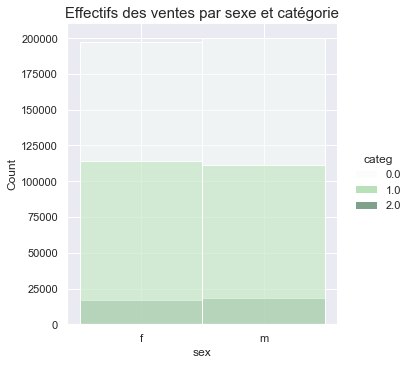

In [69]:
#Représentation graphique des données 
plt.figure(figsize=(12, 5))
sns.displot(data=data, x='sex', hue='categ',palette='Greens' )
plt.title('Effectifs des ventes par sexe et catégorie', fontsize=15)
plt.show()

L'intérêt du test du Khi² est de mesurer l'indépendance entre deux variables qualitatives à partir du tableau de contigence.  
On pose les hypothèses de départ :
- H0 : Variables indépendantes si p-value > 5%
- H1 : Variables non indépendantes si p-value < 5%

In [70]:
#Creation du tableau de contingence pour calculer Khi2
crosstab_SC = pd.crosstab(data['categ'], data['sex'], margins=False)
print('Table de contingence :')
print(crosstab_SC)

Table de contingence :
sex         f       m
categ                
0.0    197385  200081
1.0    114258  111587
2.0     16746   18607


Conditions

Le test de normalité ne fait pas partie des conditions du khi-deux, vu qu'on ne mesure pas la normalité que sur des variables quantitatives.

On doit malgré tout valider 2 conditions :

- au moins 1 valeur dans chaque cellule de la table de contingence
- au moins 80% des valeurs égales ou supérieures à 5
> Conditions ok

La cardinalité est le nombre de modalités dans les 2 qualitatives à étudier. 
Plus la cardinalité sera grande, plus il sera difficile de séparer distinctement les groupes.
On mesure cette cardinalité en degrés de liberté :  
Degrés de liberté = ( nombre de modalités variable_A - 1 ) x ( nombre de modalités variable_B - 1 )  
Degrés de liberté = (2-1) x (3-1) = 1 x 2 = 2  
On obtient donc 2 degrés de liberté dans la table de contingence entre 'categ' et 'sex'. (vérifié par stats_dof)

In [71]:
#Calcul du khi2 et de la pvalue à partir de la matrice des valeurs observées Via scipy.stats.chi2_contingency
stats_chi2, stats_p, stats_dof, stats_exp = stats.chi2_contingency(crosstab_SC)

In [72]:
#Chi2
stats_chi2

142.44083074174475

In [73]:
#degré de liberté (calculé plus haut manuellement)
stats_dof

2

In [74]:
#P-Value
stats_p

1.173185280916168e-31

H0 : Variables indépendantes si p-value > 5%  
<b><font color ='#148F77'> H1 : Variables non indépendantes si p-value < 5% </font></b>

<b>Interpretation : </b>  
- dans un premier temps nous pouvons voir qu'il y une certaine parité des genre entre les catégories.
- ensuite nous constatons une légère dépendance entre les variables, en effet notre P-value est inférieur à 0,05.

## 2. Age vs Price

Je vérifie que ma relation est linéaire (je vérifie si le nuage de point peut s'ajuster correctement à une droite).

In [75]:
#Courbe de regression linéaire
import statsmodels.api as sm

X = data[['age']]
Y = data['price']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

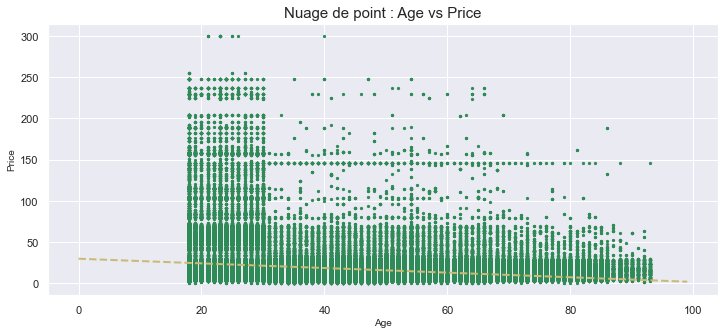

In [76]:
#Nuage de point
plt.figure(figsize =(12,5))
x = data['age']
y = data['price']
plt.scatter(x, y, marker='o', s=5, color='seagreen')
plt.plot(np.arange(100),[a*x+b for x in np.arange(100)], 'y--', lw=2)#verification linéaire
plt.title('Nuage de point : Age vs Price', fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

Calcul Pearson & Covariance, nous recherchons à déterminer l’absence ou la présence d’une relation linéaire significative entre les variables. 

In [77]:
# R² - Pearson (Or correlation) Coefficient
coefcor = stats.pearsonr(data['age'], data['price'])[0]
print(f"Correlation Coefficient (R²): {coefcor:.2f}")

# σxy - Covariance (mesure la relation, l'association entre deux variables)
covariance = np.cov(data['age'], data['price'])[0][1]
print(f"Covariance (σxy): {covariance:.2f}")

Correlation Coefficient (R²): -0.21
Covariance (σxy): -52.09


<b> Interpretation : </b> le coefficient de correaltion montre une légère correlation négative entre les variable confirmée par la covariance.

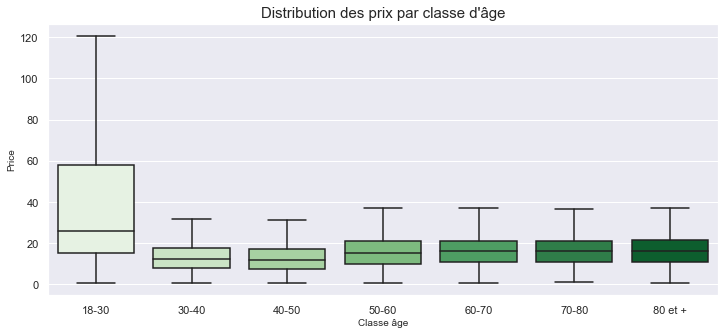

In [78]:
#Boxplot classe age / price
plt.figure(figsize =(12,5))
sns.boxplot( x=data["classe_age"].sort_values(), y=data["price"], showfliers=False, palette='Greens' )
plt.title("Distribution des prix par classe d'âge", fontsize=15 )
plt.xlabel('Classe âge', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

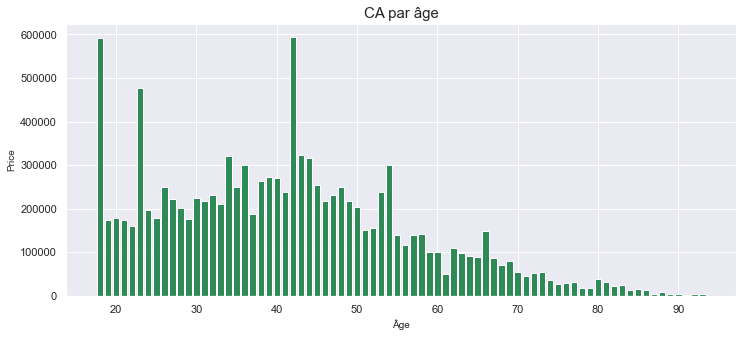

In [79]:
gp_age = data.groupby("age").agg({"price": np.sum, "id_prod": np.size}).reset_index()
plt.figure(figsize=(12,5))
plt.bar(gp_age['age'], gp_age['price'], color = 'seagreen')
plt.title("CA par âge", fontsize=15 )
plt.xlabel('Âge', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

<b> Interprétation :</b> Les clients jeunes (18 - 30 ans) ont tendance à acheter des produits plus chers. On voit que c'est la tranche 18 ans et 23 ans qui fait remonter les scores. Mais ils n'achètent pas en quantité.

## 3. Age VS Fréquence d'achat

In [80]:
# Creation d'un df avec le nombre d'achat par yearmonth et par client_id
df = (data[['age', 'client_id', 'yearmonth', 'price']].copy()
          .groupby(['client_id', 'age', 'yearmonth'])
          .count()
          .unstack()
          .fillna(0))
df.sample()

price                                                          \
yearmonth     202103 202104 202105 202106 202107 202108 202109 202110 202111   
client_id age                                                                  
c_377     31     9.0    8.0    9.0   17.0    6.0   11.0   15.0    0.0    4.0   

                      ...                                                   \
yearmonth     202112  ... 202205 202206 202207 202208 202209 202210 202211   
client_id age         ...                                                    
c_377     31     3.0  ...   12.0   11.0   14.0    3.0   21.0    8.0   10.0   

                                    
yearmonth     202212 202301 202302  
client_id age                       
c_377     31     9.0    5.0    6.0  

[1 rows x 24 columns]

In [81]:
#Calcul de la fréquence par client_id
df['total'] = df.mean(axis=1)
df.sample()

price                                                          \
yearmonth     202103 202104 202105 202106 202107 202108 202109 202110 202111   
client_id age                                                                  
c_2952    58     3.0    5.0    3.0    1.0   11.0    4.0   14.0    0.0    7.0   

                      ...                                                   \
yearmonth     202112  ... 202206 202207 202208 202209 202210 202211 202212   
client_id age         ...                                                    
c_2952    58     7.0  ...    3.0    1.0    7.0    4.0    4.0    7.0    7.0   

                            total  
yearmonth     202301 202302        
client_id age                      
c_2952    58     9.0    0.0  4.75  

[1 rows x 25 columns]

In [82]:
# Analyse de la variance avec la classe d'âge des clients
df1 = (df
     .reset_index()
     .rename(columns=dict(total='frequency'))[['age', 'frequency']])
df1.sample()

,age,frequency
yearmonth,,
7130,53,1.208333


Je vérifie que ma relation est linéaire avec un graphique nuage de point (je vérifie si le nuage de point peut s'ajuster correctement à une droite).                                                    

In [83]:
#Courbe de regression linéaire
X = df1[['age']]
Y = df1['frequency']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

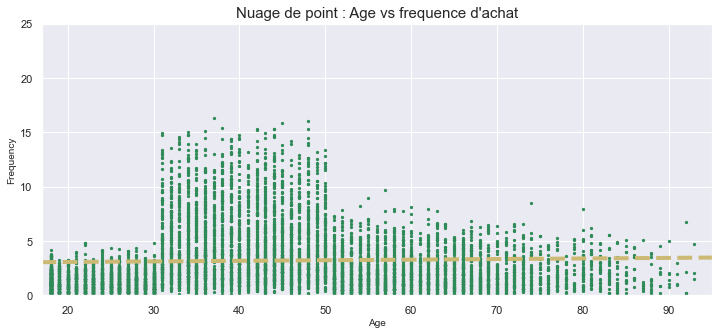

In [84]:
#Nuage de point
plt.figure(figsize =(12,5))
x = df1['age']
y = df1['frequency']
plt.scatter(x, y, marker='o', s=5,color='seagreen')
plt.plot(np.arange(100),[a*x+b for x in np.arange(100)], 'y--', lw=4)#verification linéaire
plt.title("Nuage de point : Age vs frequence d'achat", fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.xlim(xmax = 95, xmin = 17)
plt.ylabel('Frequency', fontsize=10)
plt.ylim(ymax = 25, ymin = 0)
plt.show()

<b>Calcul Pearson & Covariance </b>

In [85]:
# R² - Pearson (Or correlation) Coefficient
coefcor = stats.pearsonr(df1['age'], df1['frequency'])[0]
print(f"Correlation Coefficient (R²): {coefcor:.2f}")

# σxy - Covariance
covariance = np.cov(df1['age'], df1['frequency'])[0][1]
print(f"Covariance (σxy): {covariance:.2f}")

Correlation Coefficient (R²): 0.01
Covariance (σxy): 1.54


<b> Interpretation : </b> le coefficient de correaltion montre une correlation presque nulle entre les variable confirmée par la covariance.

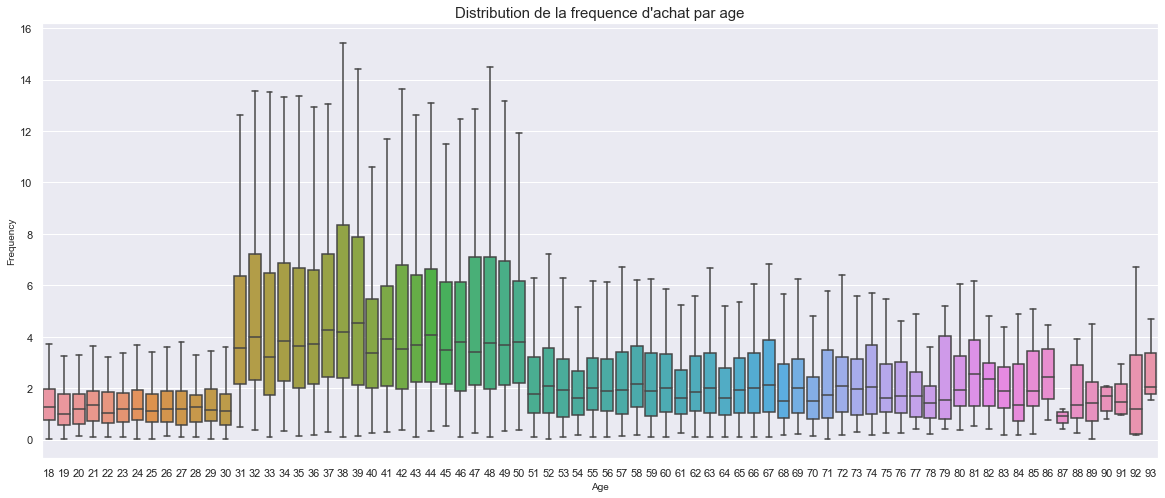

In [86]:
#Boxplot 
sns.set(rc = {'figure.figsize':(20,8)})
sns.boxplot( x=df1["age"].sort_values(), y=df1["frequency"], showfliers=False )
plt.title("Distribution de la frequence d'achat par age", fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

In [87]:
# Moyenne de la fréquence d'achat par age
df2 = (df['total']
          .reset_index()
          .drop('client_id', axis=1)
          .groupby('age')
          .mean()
          .reset_index()
          .rename(columns={'total': 'frequency'}))
df2.sample()

,age,frequency
71,89,1.651042


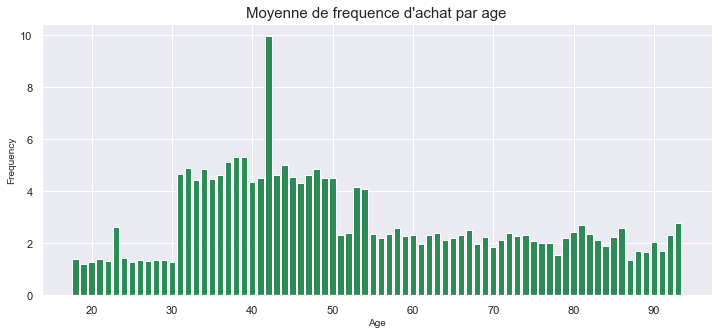

In [88]:
#Graphique
plt.figure(figsize=(12,5))
plt.bar(df2['age'], df2['frequency'], color='seagreen')
plt.title("Moyenne de frequence d'achat par age", fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

<b> Interpretation : </b>
Bien que la tranche d'âge des plus jeunes réalisent des paniers moyens (en valeur) élevés, on se rend compte ici que les achats sont peu fréquents.
La tranche d'âge qui représente la plus grande fréquence d'achats est la tranche d'age des 30 / 50 avec une moyenne d'environ cinq achats par mois.

## 4. Age VS Volume 

In [89]:
#Je créé un df pour analyser ces variable et calculer le nb de vente par age.
df3 = (data[['age', 'price']]
      .groupby('age')
      .count()
      .rename(columns=dict(price='sales'))
      .reset_index().copy())

In [90]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     76 non-null     int64
 1   sales   76 non-null     int64
dtypes: int64(2)
memory usage: 1.3 KB


Je vérifie que ma relation est linéaire (je vérifie que le nuage de point peut s'ajuster correctement à une droite).  

In [91]:
#Courbe de regression linéaire
X = df3[['age']]
Y = df3['sales']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

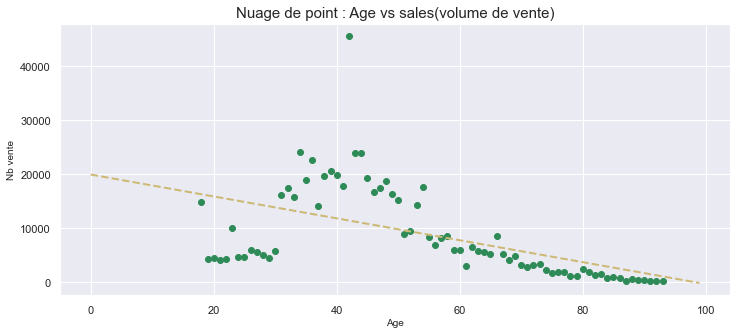

In [92]:
#Graphique
plt.figure(figsize=(12,5))
x = df3['age']
y = df3['sales']
plt.scatter(x, y, color='seagreen')
plt.plot(np.arange(100),[a*x+b for x in np.arange(100)], 'y--', lw=2)#verification linéaire
plt.title("Nuage de point : Age vs sales(volume de vente)", fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.ylabel('Nb vente', fontsize=10)
plt.show()

<b> Calcul Pearson & Covariance </b>

In [93]:
# R² - Pearson (Or correlation) Coefficient
coefcor = stats.pearsonr(df3['age'], df3['sales'])[0]
print(f"Correlation Coefficient (R²): {coefcor:.2f}")

# σxy - Covariance
covariance = np.cov(df3['age'], df3['sales'])[0][1]
print(f"Covariance (σxy): {covariance:.2f}")

Correlation Coefficient (R²): -0.54
Covariance (σxy): -99035.73


<b> Interpretation : </b> le coefficient de correlation montre une correlation négative entre les variable confirmée par la covariance.

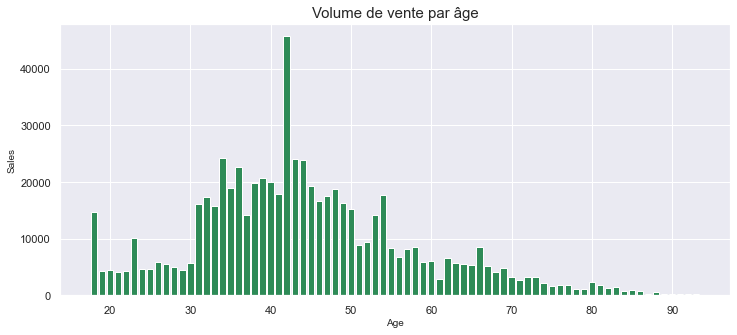

In [94]:
# Volume des ventes par âge
plt.figure(figsize=(12,5))
plt.bar(df3['age'], df3['sales'], color='seagreen')
plt.title("Volume de vente par âge", fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.ylabel('Sales', fontsize=10)
plt.show()

<b> Interprétation : </b>les clients qui achètent le plus ont entre 31 ans et 50ans. Du côté des jeunes (18-30ans) les 18 et 23 ans relèvent un peu les stats de cette portion.

## 5. Age VS panier moyen (volume)

In [95]:
# Je créé un nouveau df pour anlyser ces variables et calculer mon panier moyen
df4 = (data[['session_id', 'age', 'price']]
      .groupby(['session_id', 'age'])
      .count()
      .reset_index()
      .rename(columns=dict(price='products')))

In [96]:
df4.sample()

,session_id,age,products
285827,s_5748,56,4


Je vérifie que ma relation est linéaire (je vérifie que le nuage de point peut s'ajuster correctement à une droite).  

In [97]:
#Courbe de regression linéaire
X = df4[['age']]
Y = df4['products']
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['age'],result.params['intercept']

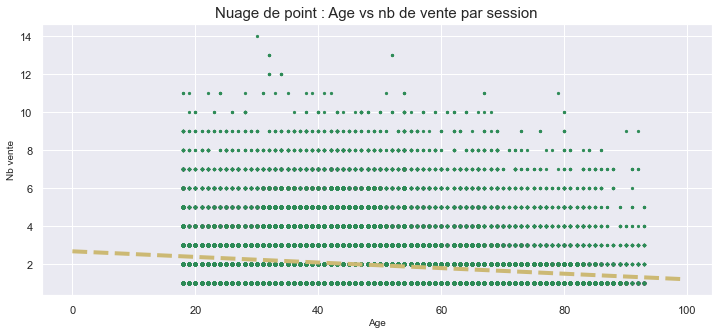

In [98]:
# Nuage de point
plt.figure(figsize=(12,5))
x = df4['age']
y = df4['products']
plt.scatter(x, y, s=5, marker='o',color='seagreen')
plt.plot(np.arange(100),[a*x+b for x in np.arange(100)], 'y--', lw=4)#verification linéaire
plt.title("Nuage de point : Age vs nb de vente par session", fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.ylabel('Nb vente', fontsize=10)
plt.show()

<b>Calcul Pearson & Covariance</b>

In [99]:
# R² - Pearson (Or correlation) Coefficient
coefcor = stats.pearsonr(df4['age'], df4['products'])[0]
print(f"Correlation Coefficient (R²): {coefcor:.2f}")

# σxy - Covariance
covariance = np.cov(df4['age'], df4['products'])[0][1]
print(f"Covariance (σxy): {covariance:.2f}")

Correlation Coefficient (R²): -0.17
Covariance (σxy): -3.29


<b> Interpretation : </b> le coefficient de correlation montre une légère correlation négative entre les variables.

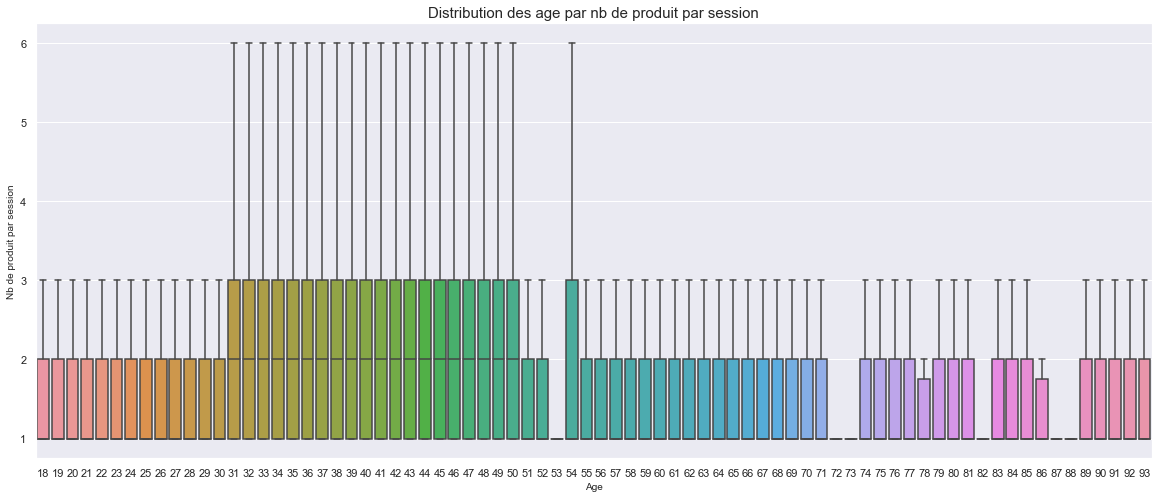

In [100]:
#Distribution du nb de produit par session par âge
sns.set(rc = {'figure.figsize':(20,8)})
sns.boxplot( x=df4["age"].sort_values(), y=df4["products"], showfliers=False )
plt.title("Distribution des age par nb de produit par session", fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.ylabel('Nb de produit par session', fontsize=10)
plt.show()

In [101]:
df4.describe()# indicateurs statistiques

,age,products
count,331241.000000,331241.000000
mean,45.877385,1.988474
std,14.935290,1.276131
min,18.000000,1.000000
25%,35.000000,1.000000
50%,44.000000,2.000000
75%,55.000000,3.000000
max,93.000000,14.000000


In [102]:
#nombre de produit moyen par transactions et par age
df5 = df4.groupby('age').mean().reset_index()
df5.sample()

,age,products
48,66,1.496946


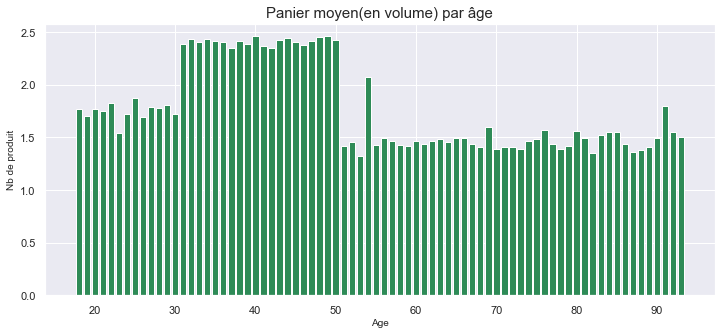

In [103]:
plt.figure(figsize=(12,5))
plt.bar(df5['age'], df5['products'], color='seagreen')
plt.title("Panier moyen(en volume) par âge", fontsize=15 )
plt.xlabel('Age', fontsize=10)
plt.ylabel('Nb de produit', fontsize=10)
plt.show()

<b>Interpretation : </b> La tranche d'âge des 30-50 est celle qui réalise les achats ayant les plus grands paniers moyens en volume.

## 5. Age VS Category

Nous sommes dans le cas ou nous avons une variable quantitative 'age' et une variable qualitative 'categ'. Pour analyser ses deux variable pous allons passer par ANOVA.

<b> Calcul ANOVA </b>
Tout d'abord on vérifie la normalité de nos donnée pour pouvoir effectuer une ANOVA.  
On pose les hypothèses de départ :
- H0 : Variable ne suit pas une loi normale si p-value > 5%  
- H1 : Variable suit une loi normale si p-value < 5%

In [104]:
#Test de normalité Kolmogorov-Smirnov
standardized_data=(data['age']-np.mean(data['age']))/np.std(data['age'])
ks_statistic,ks_p_value=stats.kstest(standardized_data, 'norm')#Compared with standard normal distribution
ks_statistic,ks_p_value

(0.08145528149422887, 0.0)

H0 : Variable ne suit pas une loi normale si p-value > 5%  
<b><font color ='#148F77'> H1 : Variable suit une loi normale si p-value < 5% </font></b>

In [105]:
#Test de normalité Lilliefors
import statsmodels.api as sm
Lilliefors_statistic,Lilliefors_p_value=sm.stats.diagnostic.lilliefors(data['age'],'norm')
Lilliefors_statistic,Lilliefors_p_value

(0.0814552987461512, 0.0009999999999998899)

H0 : Variable ne suit pas une loi normale si p-value > 5%  
<b><font color ='#148F77'> H1 : Variable suit une loi normale si p-value < 5% </font></b>

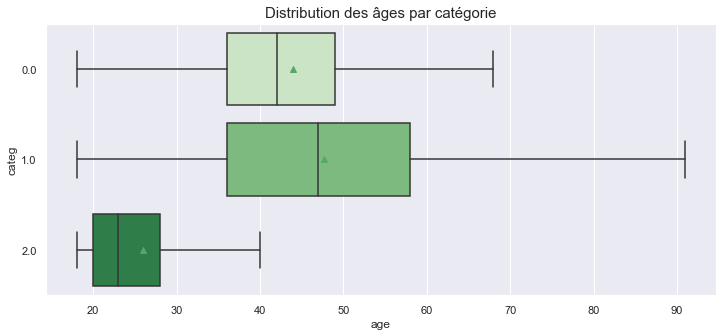

In [106]:
#Visualisons les données avec un Boxplot, je vérifie visuellement la normalité de mes données.
plt.figure(figsize=(12,5))
sns.boxplot(
    data=data, y='categ', x='age', 
    showmeans=True, showfliers=False, orient='h', palette='Greens')
plt.title('Distribution des âges par catégorie', fontsize=15)
plt.show()

Les points verts au milieu de chaque boîte à moustaches représentent la moyenne des valeurs.
On voit ici que les âges sont très différents d'une catégorie à l'autre. Par exemple, les âges de la categorie 1 sont plus élevés et plus dispersés que ceux de la categorie 1 ou 2.  

Mais vérifions maintenant cette affirmation par les chiffres, grâce à une modélisationn, calculons 𝜂2 (eta carré ou eta squared, en anglais) :

In [107]:
X = "categ" # qualitative
Y = "age" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(data[X],data[Y])

0.11882920883700403

<b> Interpretation :</b> 
- la variable qualitative influe effectivement sur la variable quantitative.
- 11% des âges peuvent être affectés à une categorie selon le test ANOVA
> eta_squared : sur la variation totale en Y, la proportion qui peut être attribuée à un X spécifique.

Pour compléter l'analyse je décide de faire une analyse de  categ avec la classe d'âge. En utilisant le test du Khi2 car 'classe_age' et 'categ' sont deux variables qualitatives.

In [108]:
#tableau de contingence
crosstab_AC = pd.crosstab(data['classe_age'], data['categ'], margins=False)
print('Table de contingence :')
print(crosstab_AC)

Table de contingence :
categ          0.0    1.0    2.0
classe_age                      
18-30        14754  27600  29890
30-40       129287  42993   2895
40-50       166034  52938    758
50-60        49702  52609    995
60-70        23529  30704    526
70-80         9362  12491    168
80 et +       4798   6510    121


Conditions

Le test de normalité ne fait pas partie des conditions du khi-deux, vu qu'on ne mesure pas la normalité que sur des variables quantitatives.

On doit malgré tout valider 2 conditions :

- au moins 1 valeur dans chaque cellule de la table de contingence
- au moins 80% des valeurs égales ou supérieures à 5
> Conditions ok

#Calcul Khi2 : on pose les hypothèses de départ :

H0 : Variables indépendantes si p-value > 5%  
H1 : Variables non indépendantes si p-value < 5%

Calcul du khi2 et de la pvalue à partir de la matrice des valeurs observées Via scipy.stats.chi2_contingency

In [109]:
stats_chi2, stats_p, stats_dof, stats_exp = stats.chi2_contingency(crosstab_AC)

In [110]:
#Chi2
stats_chi2

268883.75817996805

In [111]:
#Dedré de liberté
stats_dof

12

In [112]:
#P-value
stats_p

0.0

H0 : Variables indépendantes si p-value > 5%  
<b><font color ='#148F77'> H1 : Variables non indépendantes si p-value < 5% </font></b>

<b> Interpretation :</b> 0 étant inférieur à notre p-value de 0,05, nous pouvons dire qu'il y a une legere dépendance entre les deux variables.

## 6. Categ VS Price

Nous sommes dans le cas ou nous avons une variable quantitative 'price' et une variable qualitative 'categ'.
Pour analyser ses deux variable pous allons passer par ANOVA.

<b> Calcul ANOVA </b>
Tout d'abord on vérifie la normalité de nos donnée pour pouvoir effectuer une ANOVA.  
On pose les hypothèses de départ :
- H0 : Variable ne suit pas une loi normale si p-value > 5%  
- H1 : Variable suit une loi normale si p-value < 5%

In [113]:
#Test de normalité Kolmogorov-Smirnov
standardized_data=(data['price']-np.mean(data['price']))/np.std(data['price'])
ks_statistic,ks_p_value=stats.kstest(standardized_data, 'norm')#Compared with standard normal distribution
ks_statistic,ks_p_value

(0.23000828855933964, 0.0)

H0 : Variable ne suit pas une loi normale si p-value > 5%  
<b><font color ='#148F77'> H1 : Variable suit une loi normale si p-value < 5% </font></b>

In [114]:
#Test de normalité Lilliefors
import statsmodels.api as sm
Lilliefors_statistic,Lilliefors_p_value=sm.stats.diagnostic.lilliefors(data['price'],'norm')
Lilliefors_statistic,Lilliefors_p_value

(0.23000832869842092, 0.0009999999999998899)

H0 : Variable ne suit pas une loi normale si p-value > 5%  
<b><font color ='#148F77'> H1 : Variable suit une loi normale si p-value < 5% </font></b>

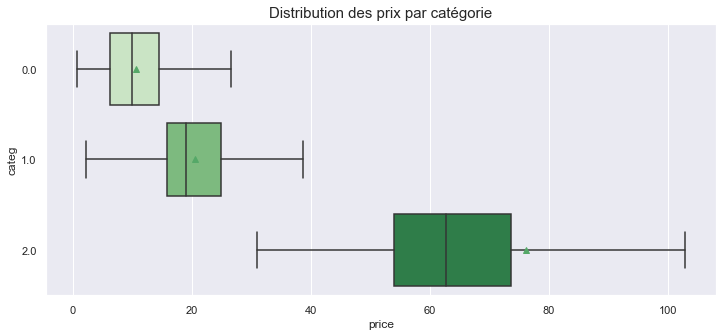

In [115]:
#Visualisons les données avec un Boxplot, je vérifie visuellement la normalité de mes données.
plt.figure(figsize=(12,5))
sns.boxplot(
    data=data, y='categ', x='price', 
    showmeans=True, showfliers=False, orient='h', palette='Greens')
plt.title('Distribution des prix par catégorie', fontsize=15)
plt.show()

Les points verts au milieu de chaque boîte à moustaches représentent la moyenne des valeurs.
On voit ici que les montants sont très différents d'une catégorie à l'autre. Par exemple, les prix de la categorie 2 sont plus élevés et plus dispersés que ceux de la categorie 1 ou 2.  

Mais vérifions maintenant cette affirmation par les chiffres, grâce à une modélisationn calculons 𝜂2 (eta carré ou eta squared, en anglais) :

In [116]:
X = "categ" # qualitative
Y = "price" # quantitative
    
eta_squared(data[X],data[Y])

0.6446229798387937

<b> Interpretation :</b> 
- la variable qualitative influe effectivement sur la variable quantitative.
- 64% des prix peuvent être affectés à une categorie selon le test ANOVA
> eta_squared : sur la variation totale en Y, la proportion qui peut être attribuée à un X spécifique.